# Run full Granual Predictions

What needs to happen:
- function to temporally and spatially interpolate MERRA2 
- function to read MERRA2 with interpolation
  - PS = surface_pressure
  - T10M = 10-meter_air_temperature (Andy will investigate)
  - TO3 = total_column_ozone
  - TQV = total_precipitable_water_vapor
- function to read VNP02MOD
  - observation_data
    - M14 (for center wavelengths at 8500 nm)
    - M15 (for center wavelengths at 10800 nm)
    - M16 (for center wavelengths at 12000 nm)
- function to read VNP03MOD
  - geolocation_data
    - sensor_azimuth
    - sensor_zenith
    - solar_azimuth
    - solar_zenith
- function to combine above for model inputs

## Setup

In [1]:
from pathlib import Path

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from hot_dust import preprocess, DATADIR

In [2]:
open_vnp02 = xr.open_dataset(
    "data/granules/VNP02MOD.A2020168.1448.002.2021127084950.nc",
    group="observation_data",
    mask_and_scale=False,
) 

# Check for the fill value 
open_vnp02 = xr.where(open_vnp02 >= 65527, np.nan, open_vnp02) #TODO stack, drop nan (drop same indices from others), convert to int, unstack

# Access the relavant variables
vnp02_variables = open_vnp02[
    [
        "M14",
        "M14_brightness_temperature_lut",
        "M15",
        "M15_brightness_temperature_lut",
        "M16",
        "M16_brightness_temperature_lut",
    ]
]

vnp02_variables 

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float64 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float64 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float64 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...

In [3]:
open_vnp03 = xr.open_dataset(
    "data/granules/VNP03MOD.A2020168.1448.002.2021125194020.nc",
    group="geolocation_data",
)

# Access the relavant variables
vnp03_variables = open_vnp03[
    ["sensor_azimuth", "sensor_zenith", "solar_azimuth", "solar_zenith"]
]  
open_vnp03

<xarray.Dataset>
Dimensions:          (number_of_lines: 3232, number_of_pixels: 3200)
Dimensions without coordinates: number_of_lines, number_of_pixels
Data variables:
    latitude         (number_of_lines, number_of_pixels) float32 ...
    longitude        (number_of_lines, number_of_pixels) float32 ...
    height           (number_of_lines, number_of_pixels) float32 ...
    range            (number_of_lines, number_of_pixels) float32 ...
    sensor_azimuth   (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith    (number_of_lines, number_of_pixels) float32 ...
    solar_azimuth    (number_of_lines, number_of_pixels) float32 ...
    solar_zenith     (number_of_lines, number_of_pixels) float32 ...
    land_water_mask  (number_of_lines, number_of_pixels) float32 ...
    water_present    (number_of_lines, number_of_pixels) float32 ...
    quality_flag     (number_of_lines, number_of_pixels) uint8 ...

In [27]:
# Merge the model imputs
vnp02_vnp03 = xr.merge([vnp02_variables, vnp03_variables])
print(vnp02_vnp03) 

# Stack the model inputs (did this in the blocks of code for merra)
#vnp02_vnp03.stack(stack_dim=('number_of_lines', 'number_of_pixels'))

# Create a mask for the NaN values and fill them   
nan_mask = xr.where(np.isnan(vnp02_vnp03), True, False)
vnp02_vnp03 = vnp02_vnp03.where(~nan_mask, other=-999.99)


# Drop the NaN values (didn't work)
#vnp02_vnp03 = vnp02_vnp03.dropna(dim= 'number_of_lines') 
#vnp02_vnp03 = vnp02_vnp03.dropna(dim= 'number_of_pixels') 

# Convert temperature variables to integers
vnp02_vnp03["M14"] = vnp02_vnp03["M14"].astype(int)
vnp02_vnp03["M15"] = vnp02_vnp03["M15"].astype(int)
vnp02_vnp03["M16"] = vnp02_vnp03["M16"].astype(int)

# Multiply them within the xarray 
vnp02_vnp03["M14"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M14"]]
vnp02_vnp03["M15"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M15"]]
vnp02_vnp03["M16"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M16"]]  

vnp02_vnp03

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float64 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float64 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float64 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...
    sensor_azimuth                  (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith                   (number_of_lines, number_of_pixels) float32 .

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float32 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float32 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float32 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...
    sensor_azimuth                  (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith                   (number_of_lines, number_of_pixels) float32 ...
    solar_azimuth                   (number_of_lines, number_of_pixels) float32 ...
    solar_zenith                    (number_of_lines, number_of_pixels) float32 ...

## Extract MERRA-2 Input Variables



In [28]:
pass
%%time
# opendap on station101, vscode timing == 7m 15.6s
# s3 on openscapes.2i2c.cloud, magics time == 1min 11s
# import earthaccess

# auth = earthaccess.login(strategy="netrc", persist=True)
# fs = earthaccess.get_s3fs_session("GES_DISC")
fs = None
granule = DATADIR / "granules"
for item in granule.glob("VNP03*"):
    ds = preprocess.get_merra_variables(item, fs)
    ds.to_netcdf(DATADIR / "merra" / item.name) 

UsageError: Line magic function `%%time` not found.


In [29]:
(DATADIR / 'merra').exists() 
directory_path = (DATADIR / 'merra').glob('*.nc')  
list(directory_path)

[WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020168.1448.002.2021125194020.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020169.0318.002.2021125194543.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020169.1430.002.2021125195004.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020170.0300.002.2021125195511.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020170.1412.002.2021125200321.nc')]

In [30]:
# Merge all the merra files 
directory_path = (DATADIR / 'merra'/ 'VNP03MOD.A2020168.1448.002.2021125194020.nc')
merra_variables = xr.open_dataset(directory_path) 
merra_variables = merra_variables.drop(['time', 'lon', 'lat']) # Drop the coordinates 

merra_variables 

<xarray.Dataset>
Dimensions:  (number_of_lines: 3232, number_of_pixels: 3200)
Dimensions without coordinates: number_of_lines, number_of_pixels
Data variables:
    PS       (number_of_lines, number_of_pixels) float64 ...
    TS       (number_of_lines, number_of_pixels) float64 ...
    TO3      (number_of_lines, number_of_pixels) float64 ...
    TQV      (number_of_lines, number_of_pixels) float64 ...

In [31]:
# xr stack number of lines and pixels vnp03 and vnp02 make it 1D using the stack function
variables_merged = xr.merge([vnp02_vnp03, merra_variables], compat='override') # Merge 1st, then stack
variables_stacked = variables_merged.stack(dims_stacked = ('number_of_lines', 'number_of_pixels'))
variables_stacked

<xarray.Dataset>
Dimensions:                         (dims_stacked: 10342400,
                                     number_of_LUT_values: 65536)
Coordinates:
  * dims_stacked                    (dims_stacked) object MultiIndex
  * number_of_lines                 (dims_stacked) int64 0 0 0 ... 3231 3231
  * number_of_pixels                (dims_stacked) int64 0 1 2 ... 3198 3199
Dimensions without coordinates: number_of_LUT_values
Data variables: (12/14)
    M14                             (dims_stacked) float32 354.0 354.0 ... 354.0
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (dims_stacked) float32 354.0 354.0 ... 354.0
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (dims_stacked) float32 354.0 354.0 ... 354.0
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...
    ...                              ...
    solar_azimuth                   (dims_stacked) float32 -63.71 ... -167.4
    solar_zenith                    (dims_stacked) float32 34.4 34.39 ... 3.32
    PS                              (dims_stacked) float64 9.658e+04 ... 1.02...
    TS                              (dims_stacked) float64 305.7 305.7 ... 298.2
    TO3                             (dims_stacked) float64 280.1 280.1 ... 297.6
    TQV                             (dims_stacked) float64 41.32 41.34 ... 32.62

## 2D Plot of Input Variables

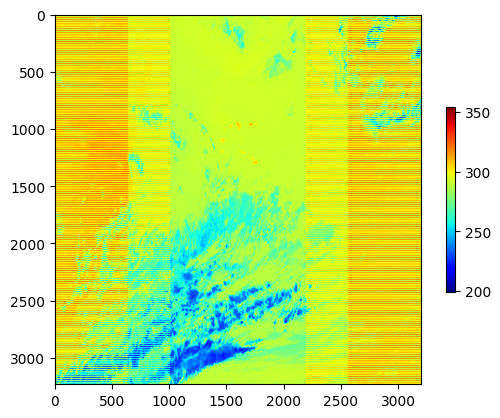

In [32]:
# M14 Map
plt.imshow(vnp02_vnp03["M14"], cmap="jet")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()  

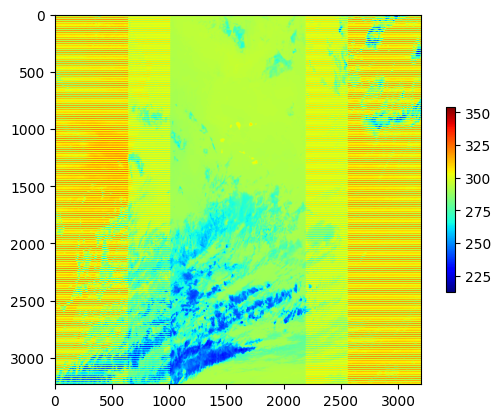

In [33]:
# M15 Map
plt.imshow(vnp02_vnp03["M15"], cmap="jet")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

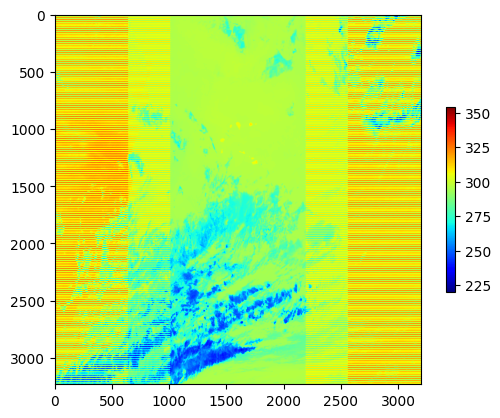

In [34]:
# M16 Map
plt.imshow(vnp02_vnp03["M16"], cmap="jet")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

## 2D Plot of Predicted Dust Optical Thickness

## WIP / Scratch

In [35]:
xr.open_dataset("data/rt_nn_irdust_training_data.nc")

<xarray.Dataset>
Dimensions:                 (npoints: 250000, nbands_viirs: 3)
Coordinates:
  * nbands_viirs            (nbands_viirs) float32 8.5e+03 1.08e+04 1.2e+04
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle      (npoints) float32 ...
    viewing_zenith_angle    (npoints) float32 ...
    relative_azimuth_angle  (npoints) float32 ...
    viirs_bts               (nbands_viirs, npoints) float32 ...
    dust_optical_thickness  (npoints) float32 ...
    dust_central_height     (npoints) float32 ...
    spress                  (npoints) float32 ...
    h2o                     (npoints) float32 ...
    o3                      (npoints) float32 ...
    ws                      (npoints) float32 ...
    ts                      (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 20230803
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [36]:
xr.open_dataset("data/granules/GMAO_MERRA2.20200616T140000.MET.nc")

<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    PS        (lat, lon) float32 ...
    QV10M     (lat, lon) float32 ...
    SLP       (lat, lon) float32 ...
    T10M      (lat, lon) float32 ...
    TO3       (lat, lon) float32 ...
    TQV       (lat, lon) float32 ...
    U10M      (lat, lon) float32 ...
    V10M      (lat, lon) float32 ...
    FRSNO     (lat, lon) float32 ...
    FRSEAICE  (lat, lon) float32 ...
Attributes: (12/39)
    date_created:                      2022-03-02T06:13:36Z
    title:                             GMAO MERRA2 2D Hourly,  Instantaneous,...
    product_name:                      GMAO_MERRA2.20200616T140000.MET.nc
    history:                           gmao_met_merge -asm MERRA2_400.inst1_2...
    time_coverage_start:               2020-06-16T14:00:00Z
    time_coverage_end:                 2020-06-16T14:00:00Z
    ...                                ...
    identifier_product_doi:            10.5067/3Z173KIE2TPD;10.5067/RKPHT8KC1...
    processing_level:                  L4
    cdm_data_type:                     grid
    spatialResolution:                 0.5x0.625 degrees
    source:                            MERRA2_400.inst1_2d_asm_Nx.20200616.nc...
    comment:                           This file contains a subset of variabl...